# Creating a General Purpose Potential for Molecular Crystals - Part 4

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D3 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- Tests...

### Import modules, functions, and necessary raw data from parts 1, 2 and 3

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed, parallel_backend

import pickle
import numpy as np
from numpy.random import RandomState
random_state = RandomState(0)
from sklearn import linear_model
import skcosmo.feature_selection
#from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR, FPS
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, callbacks, dump, load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time, sleep

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score, get_optimal_radial_basis_hypers
from rascal.utils.io import load_json, dump_json

In [2]:
#Import SOAP Bayesian optimisation modules
import sys  
sys.path.insert(0, '../code/SOAP-bayes/')
from helpers import get_features_in_parallel, get_optimal_radial_basis_hypers_parallel
from feature_skcosmo import atom_groups_by_frame

In [3]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('forces') 
        iat += len(frm)
    return frc

def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

def get_features_parallel(atoms_objects, bsize=1000, n_cores = 4):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        Do this in parallel
    '''
    blocks = []
    for iblk, blk in enumerate(range(0, len(atoms_objects), bsize)):
        blocks.append(atoms_objects[iblk*bsize:(iblk+1)*bsize])
    with parallel_backend(backend="loky"):
        results = Parallel(n_jobs=n_cores)(delayed(get_features)(frames, batch_size=10000, 
                                                                 progress_bar=False) for frames in blocks)

    return np.concatenate(results)

def predict_batched(frames, ml_model):
    man_pred = soap.transform(frames)
    return ml_model.predict(man_pred)

In [4]:
#Import raw data
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
val_set = np.load('raw_data/CSD-10k_val_set.npy', allow_pickle=True)
test_set = np.load('raw_data/CSD-10k_test_set.npy', allow_pickle=True)
X_train = np.load('raw_data/X_train.npy') 
y_train = np.load('raw_data/y_train.npy')
X_val = np.load('raw_data/X_val.npy') 
y_val = np.load('raw_data/y_val.npy')
X_test = np.load('raw_data/X_test.npy') 
y_test = np.load('raw_data/y_test.npy')
X_train_fps = np.load('raw_data/X_train_fps.npy')
y_train_fps = np.load('raw_data/y_train_fps.npy')
fps_ids = np.load('raw_data/CSD-10k_train_set_FPS_ids.npy')
fps_dist = np.load('raw_data/CSD-10k_train_set_FPS_dist.npy')
with open('raw_data/mlr.pkl', 'rb') as mlr_file:
    mlr = pickle.load(mlr_file)
initial_train_set = np.load('raw_data/initial_train_set_4pc.npy', allow_pickle=True)
train_set_FPS = np.load('model_data/train_set_FPS.npy', allow_pickle=True)

### Compute necessary data and define SOAP

In [5]:
#Compute training, validation and testing data
#Get training data for the FPS-sorted training set
ytF = []
for ifrm, frm in enumerate(train_set_FPS):
    ytF.append(frm.info['energy'])
ytrain_FPS = np.array(ytF)

#Get true energies and forces for validation set
yvt = []
fvt = []

for frm in val_set:
    yvt.append(frm.info['energy'])
    fvt.append(frm.get_array('forces'))

yval_true = np.array(yvt)
fval_true = np.concatenate(fvt)

#Get true energies and forces for test set
ytt = []
ftt = []

for frm in test_set:
    ytt.append(frm.info['energy'])
    ftt.append(frm.get_array('forces'))

ytest_true = np.array(ytt)
ftest_true = np.concatenate(ftt)

#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

In [6]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

## Test without gradients
Model seems to perform poorly with not much explanation why... should try and recreate model using `compute_gradients = False ` 

In [8]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [45]:
#get features
start = time()
print("Calculating features...")
train_set_FPS_feats = soap.transform(train_set_FPS)
print("Time taken =", time()-start)

Calculating features...
Time taken = 135.29680490493774


In [69]:
#Define kernel
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [57]:
start = time()
print("Computing kernel...")
Knm = kernel(train_set_FPS_feats, X_sparse_FPS)
print("Time taken = ", time()-start)

Computing kernel...
Time taken =  2453.7506721019745


In [58]:
#Save kernel
np.save('model_data/Knm_kernel_no_grad', Knm)

In [8]:
Knm = np.load('model_data/Knm_kernel_no_grad.npy')

In [79]:
#Train GAP model
y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS, Knm, X_sparse_FPS, ytrain_FPS, y_dressed, 
                        grad_train=None, lambdas=[0.1, 1], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken :", time()-start)

Training GAP model...
Time taken : 11.426896333694458


In [88]:
hypers["compute_gradients"] = True
soap = SphericalInvariants(**hypers)

In [89]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

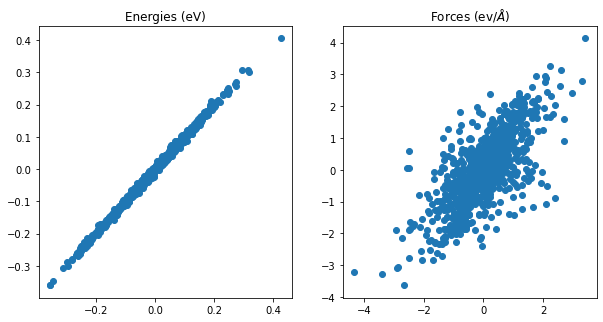

In [90]:
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

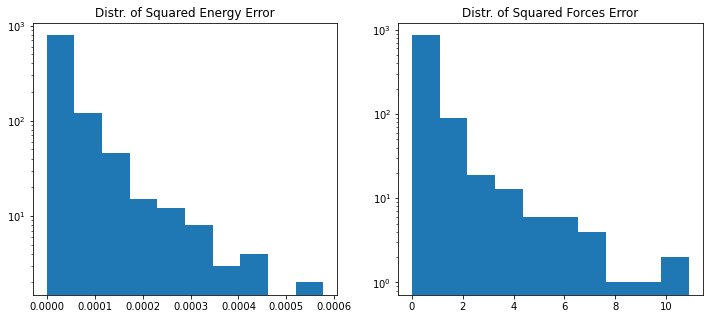

In [91]:
f,p = plt.subplots(1,2,figsize=(12,5))
p[0].hist(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2)
p[0].set_title('Distr. of Squared Energy Error')
p[0].set_yscale('log')
p[1].hist((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2)
p[1].set_title('Distr. of Squared Forces Error')
p[1].set_yscale('log')

In [92]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [93]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [94]:
print(rmse_energy, rmse_forces) #0.1, 1 lambas

0.006328508601706938 0.7465850758342991


## Test by using FPS-sorted configurations
It seems like the PCovCUR-selected configurations (8400 total) has 4807 original structures and 3593 dupicates. The first dupicate occurred after 2678 selections. This occurred even though `recompute_every` was set to 1 for the first 3000 selections, and the SOAP vector has a length of 5670.
I will therefore try and use FPS-sorted structures for the model and recompute

In [4]:
#Redefine hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [18]:
ntrain = 8400

In [8]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  136.90888285636902 s


In [9]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  419.75007581710815 s


In [108]:
dump_obj('model_data/X_sparse_FPS.json', X_sparse_FPS)

In [27]:
X_sparse_FPS = load_obj('model_data/X_sparse_FPS.json')

In [35]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

In [12]:
#Save kernel
np.save('model_data/Knm_kernel_FPS', Knm_FPS)

In [26]:
Knm_FPS = np.load('model_data/Knm_kernel_FPS.npy')

In [36]:
#Train GAP model
y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1814199 is different from 1804860)

In [ ]:
dump_obj('model_data/full_GAP_model_FPS_0.055_3.25.json', full_model)

In [38]:
full_model = load_obj('model_data/full_GAP_model_FPS_0.1_10.json')

### Predict on validation set

In [61]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

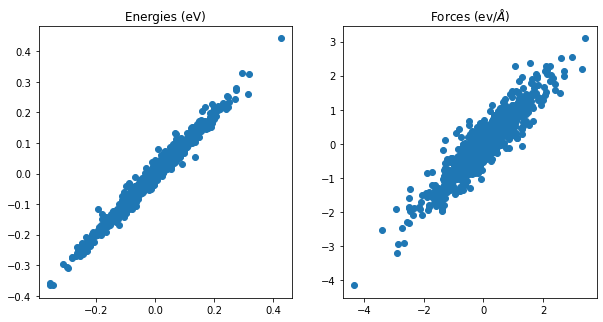

In [62]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

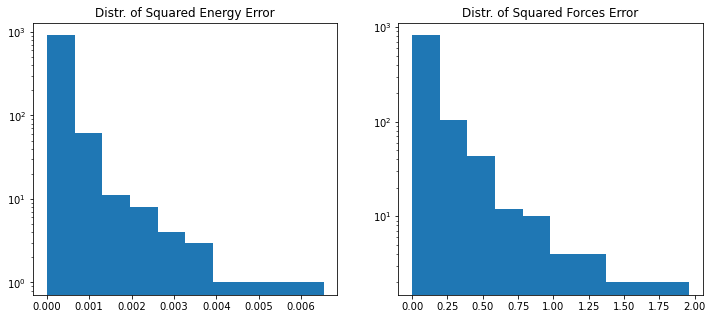

In [63]:
#Plot distribution of energy and force errors
f,p = plt.subplots(1,2,figsize=(12,5))
p[0].hist(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2)
p[0].set_title('Distr. of Squared Energy Error')
p[0].set_yscale('log')
p[1].hist((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2)
p[1].set_title('Distr. of Squared Forces Error')
p[1].set_yscale('log')

In [64]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [65]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [24]:
print(rmse_energy, rmse_forces)

0.016025078380467354 0.3435210915155982


### Predict on test set

In [39]:
#predict energies and forces for test set
npred=1000
ytp = []
ftp = []

for frm in tqdm(test_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(full_model.predict(manager_test))
    ftp.append(full_model.predict_forces(manager_test))

ytest_pred = np.array(ytp).flatten()
ftest_pred = np.concatenate(ftp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'yvp' is not defined

In [40]:
ytest_pred = np.array(ytp).flatten()
ftest_pred = np.concatenate(ftp)

Text(0, 0.5, 'Predicted force (ev / $\\AA$)')

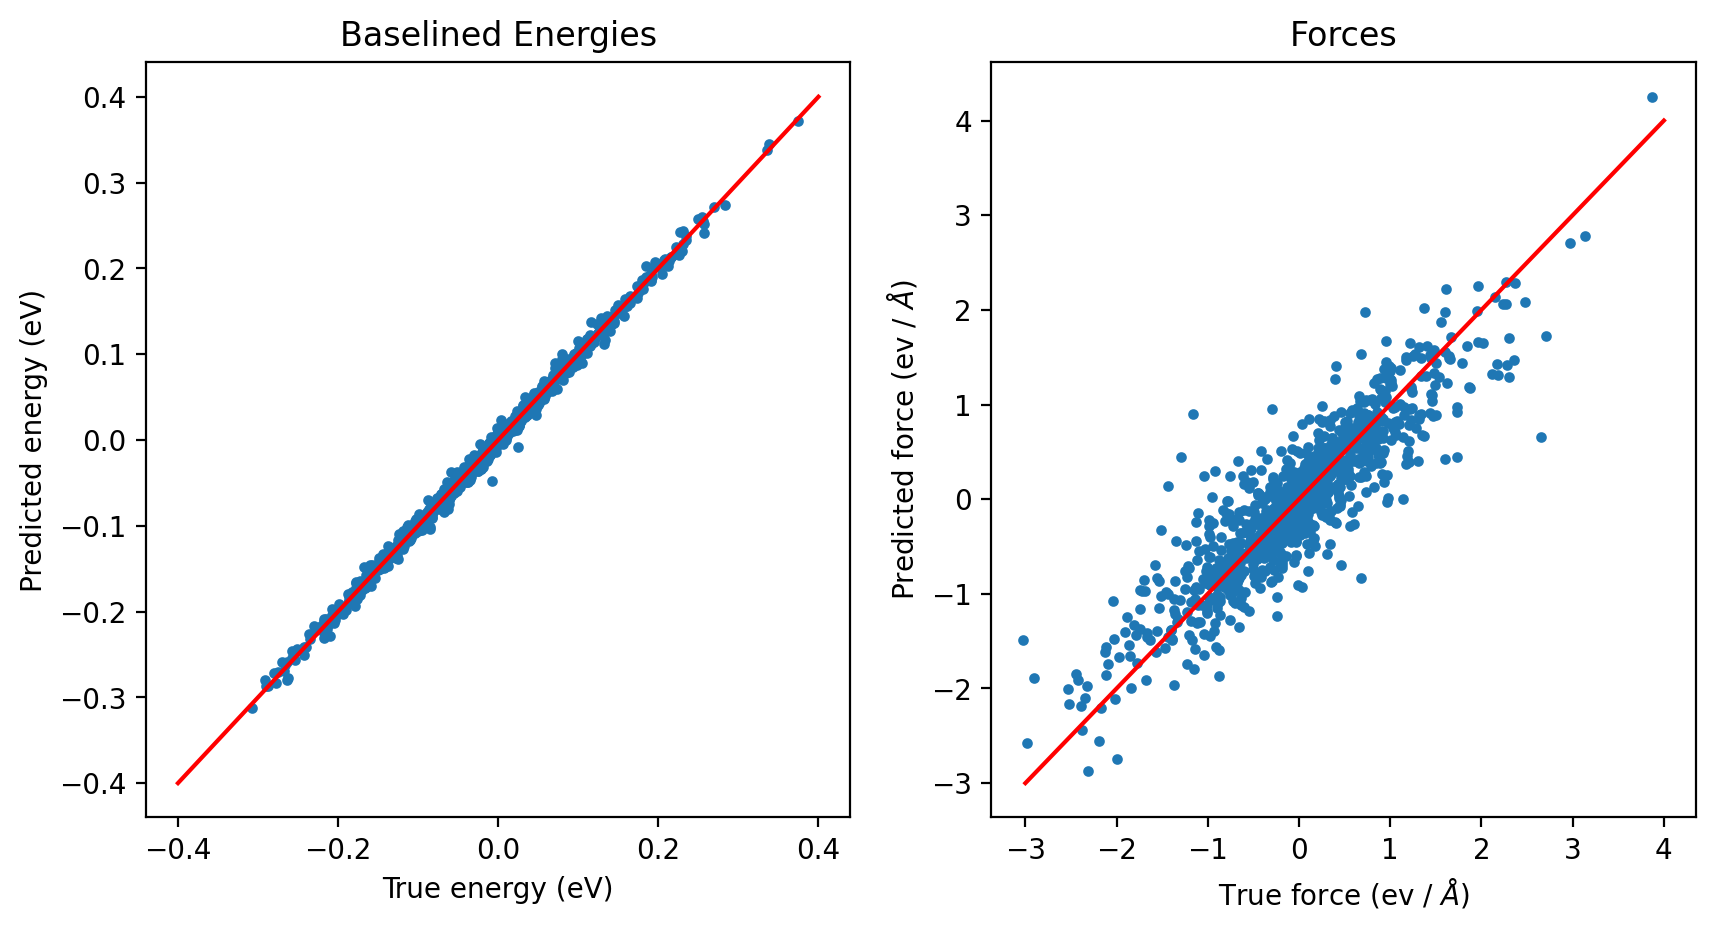

In [99]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=200)
p[0].scatter((ytest_true[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1),
             (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1), s=8)
p[0].plot([-0.4,0.4],[-0.4, 0.4], color='red')
p[0].set_title(r'Baselined Energies')
p[0].set_xlabel('True energy (eV)')
p[0].set_ylabel('Predicted energy (eV)')
p[1].scatter(ftest_true.flatten()[:npred], ftest_pred.flatten()[:npred], s=8)
p[1].plot([-3,4],[-3, 4], color='red')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (ev / $\AA$)')
p[1].set_ylabel('Predicted force (ev / $\AA$)')

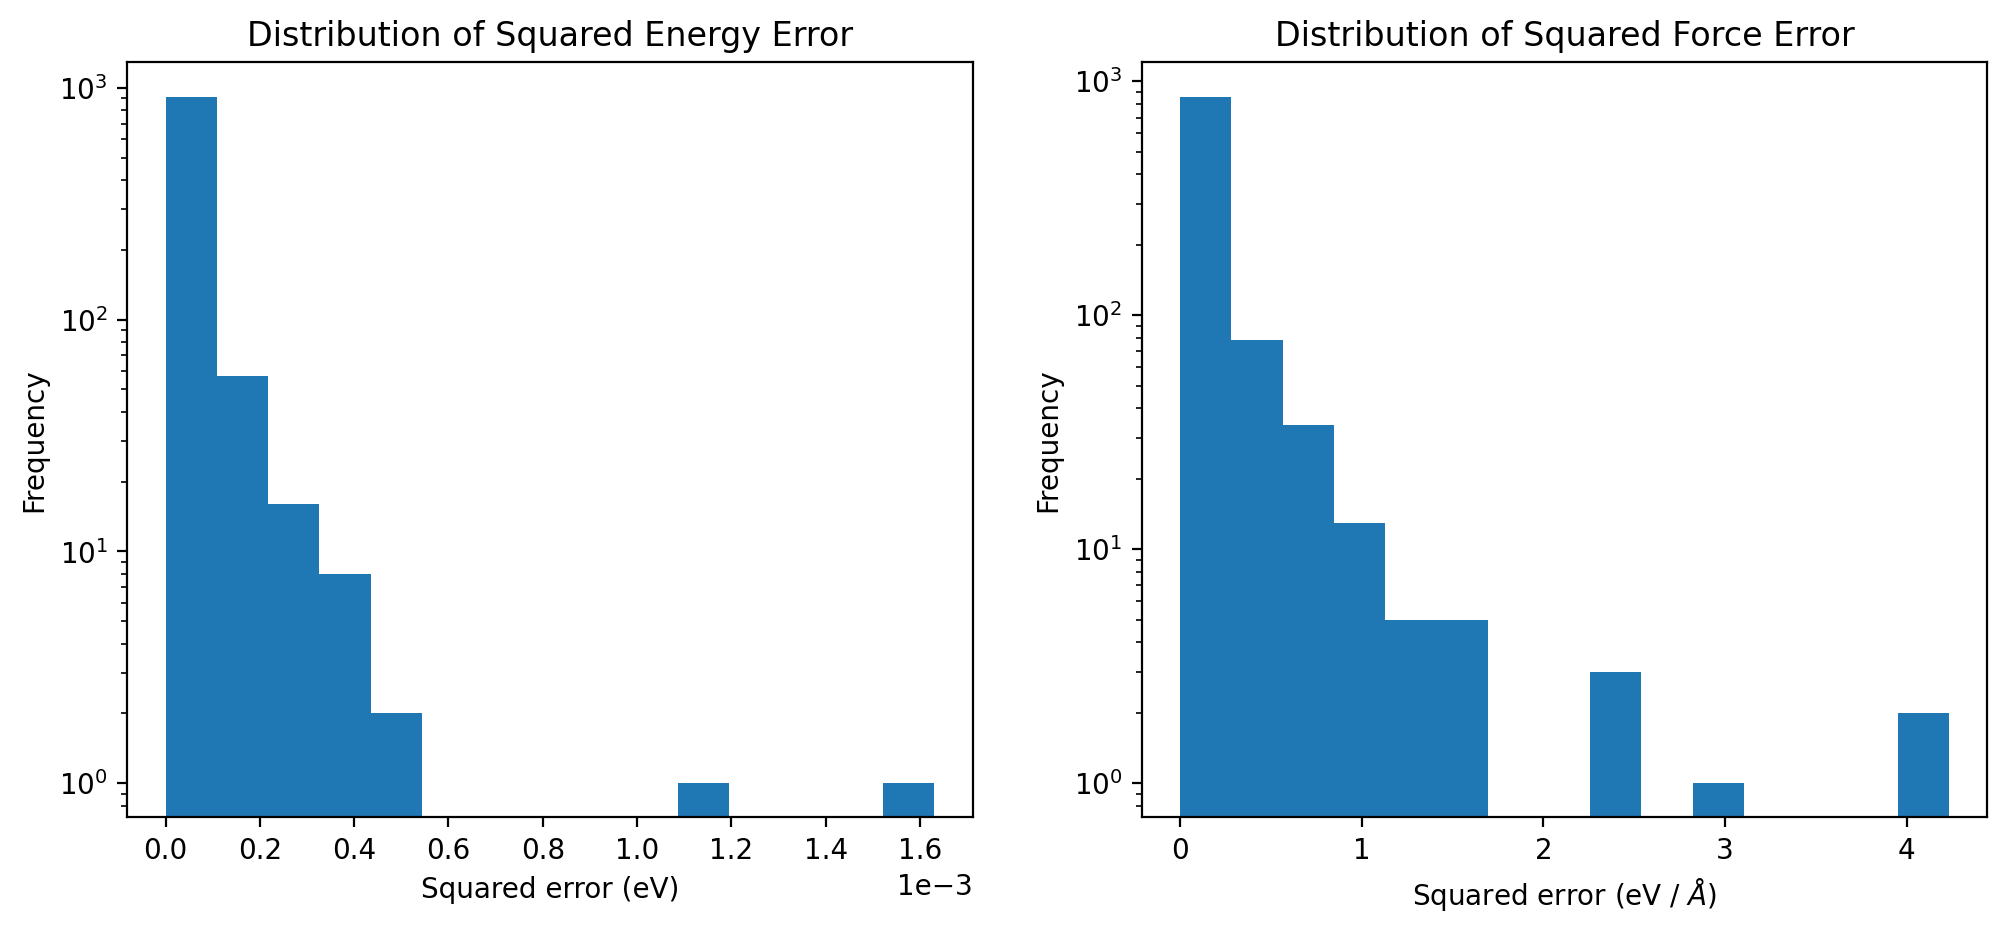

In [138]:
#Plot distribution of energy and force errors
f,p = plt.subplots(1,2,figsize=(12,5), dpi=200)
p[0].hist(((ytest_true[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1) 
           - (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1))**2, bins=15)
p[0].set_title('Distribution of Squared Energy Error')
p[0].set_yscale('log')
p[0].set_xlabel('Squared error (eV)')
p[0].set_ylabel('Frequency')
p[0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
p[1].hist((ftest_true.flatten()[:npred] - ftest_pred.flatten()[:npred])**2, bins=15)
p[1].set_title('Distribution of Squared Force Error')
p[1].set_xlabel('Squared error (eV / $\AA$)')
p[1].set_ylabel('Frequency')
p[1].set_yscale('log')

In [79]:
rmse_energy = np.sqrt(np.mean(
    ((ytest_true[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1) 
     - (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1))**2))

In [80]:
rmse_forces = np.sqrt(np.mean((ftest_true.flatten()[:npred] - ftest_pred.flatten()[:npred])**2))

In [92]:
print("RMSE energy: ", np.round(rmse_energy, 5)*1000, "meV")
print("RMSE forces: ", np.round(rmse_forces, 5)*1000, "meV")

RMSE energy:  6.28 meV
RMSE forces:  393.92 meV


### Optimise regularization parameters

In [20]:
#Loop for optimising regularization parameters
npred=100
for er in np.linspace(0.01, 0.1, 5):
    for fr in np.linspace(1, 10, 5):
        print("Testing for energy reg", er, "and force reg", fr)
        start=time()
        full_model = train_gap_model(kernel, train_set_FPS, Knm_FPS, X_sparse_FPS, ytrain_FPS, y_dressed, 
                        grad_train=-get_forces(train_set_FPS), lambdas=[er,fr], jitter=1e-9, 
                        solver = 'RKHS')
        yvp = []
        fvp = []
        for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
            manager_val = soap.transform(frm)
            yvp.append(full_model.predict(manager_val))
            fvp.append(full_model.predict_forces(manager_val))

        yval_pred = np.array(yvp).flatten()
        fval_pred = np.concatenate(fvp)
        rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
        rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
        print("Energy RMSE:", rmse_energy, "  Force RMSE:", rmse_forces, "   Time taken:", time()-start)

Testing for energy reg 0.01 and force reg 1.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006192303039853549   Force RMSE: 0.47471009817965265    Time taken: 437.71900820732117
Testing for energy reg 0.01 and force reg 3.25


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006348807262110081   Force RMSE: 0.6061431712750498    Time taken: 445.9840097427368
Testing for energy reg 0.01 and force reg 5.5


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006693312514159953   Force RMSE: 0.6787386959308281    Time taken: 444.3605704307556
Testing for energy reg 0.01 and force reg 7.75


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.0069314700412648434   Force RMSE: 0.7229571340787806    Time taken: 449.2552738189697
Testing for energy reg 0.01 and force reg 10.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.007099205901047886   Force RMSE: 0.752211407696883    Time taken: 492.4022967815399
Testing for energy reg 0.0325 and force reg 1.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.007620873736838316   Force RMSE: 0.4046416929089578    Time taken: 451.028799533844
Testing for energy reg 0.0325 and force reg 3.25


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006206255030600632   Force RMSE: 0.47611934900279446    Time taken: 449.68357944488525
Testing for energy reg 0.0325 and force reg 5.5


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006132358739724267   Force RMSE: 0.5271747117005344    Time taken: 468.9916048049927
Testing for energy reg 0.0325 and force reg 7.75


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006164274068969247   Force RMSE: 0.5689607962175919    Time taken: 436.43546175956726
Testing for energy reg 0.0325 and force reg 10.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.0062153438002083864   Force RMSE: 0.6033742808388218    Time taken: 438.5328767299652
Testing for energy reg 0.05500000000000001 and force reg 1.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.01010781837831612   Force RMSE: 0.3854278474880561    Time taken: 446.606564283371
Testing for energy reg 0.05500000000000001 and force reg 3.25


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.00652417075906656   Force RMSE: 0.4403860815218513    Time taken: 437.9965889453888
Testing for energy reg 0.05500000000000001 and force reg 5.5


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006252989308550587   Force RMSE: 0.4800507584183802    Time taken: 447.168527841568
Testing for energy reg 0.05500000000000001 and force reg 7.75


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006193810614373899   Force RMSE: 0.5145154841218803    Time taken: 458.3606288433075
Testing for energy reg 0.05500000000000001 and force reg 10.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006185213221584583   Force RMSE: 0.5455656952557194    Time taken: 462.1714117527008
Testing for energy reg 0.0775 and force reg 1.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.012776925464702483   Force RMSE: 0.3768153318710923    Time taken: 471.87202429771423
Testing for energy reg 0.0775 and force reg 3.25


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.0069939445956779195   Force RMSE: 0.42211702653896743    Time taken: 445.6918942928314
Testing for energy reg 0.0775 and force reg 5.5


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.0064572086301603136   Force RMSE: 0.45648177871837475    Time taken: 481.71364641189575
Testing for energy reg 0.0775 and force reg 7.75


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006328458450233851   Force RMSE: 0.4863305448550548    Time taken: 445.9021270275116
Testing for energy reg 0.0775 and force reg 10.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006288002768749055   Force RMSE: 0.5139688101986215    Time taken: 486.33577609062195
Testing for energy reg 0.1 and force reg 1.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.015302113828449338   Force RMSE: 0.37240063995695033    Time taken: 449.35957980155945
Testing for energy reg 0.1 and force reg 3.25


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.007612856445928489   Force RMSE: 0.41042327667560424    Time taken: 470.6727104187012
Testing for energy reg 0.1 and force reg 5.5


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006719184311644595   Force RMSE: 0.4418666883875218    Time taken: 447.42885756492615
Testing for energy reg 0.1 and force reg 7.75


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006496631874554378   Force RMSE: 0.46893946996063074    Time taken: 437.52525639533997
Testing for energy reg 0.1 and force reg 10.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Energy RMSE: 0.006421074463985387   Force RMSE: 0.4940287349908328    Time taken: 474.581178188324


## Pseudo-active learning curve for FPS-selected structures

In [23]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [78]:
train_set_FPS_feats = get_features(train_set_FPS)

  0%|          | 0/23 [00:00<?, ?it/s]

In [35]:
val_feat = get_features(val_set)

  0%|          | 0/1 [00:00<?, ?it/s]

In [81]:
X_train_FPS = np.zeros((len(train_set_FPS),4),dtype=int)
y_train_FPS = np.zeros(len(train_set_FPS))
for ifrm, frm in enumerate(train_set_FPS):
    symbols=frm.get_atomic_numbers()
    y_train_FPS[ifrm]=(frm.info['energy'])
    X_train_FPS[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

In [80]:
yred_train_FPS = y_train_FPS/np.sum(X_train_FPS,axis=1)-mlr.predict(X_train_FPS)/np.sum(X_train_FPS,axis=1)

In [81]:
structures = []
errors = []
for nstruct in [2000,4000,8000,12000,16000,20000,22617]:
    K = np.dot(train_set_FPS_feats[:nstruct], train_set_FPS_feats[:nstruct].T)**zeta #compute kernel matrix for training
    Kval = np.dot(val_feat,train_set_FPS_feats[:nstruct].T)**zeta #compute kernel matrix for validation
    KRR = KernelRidge(kernel='precomputed',alpha = 1e-9)
    KRR.fit(K,yred_train_FPS[:nstruct])
    err = np.std((yval_true - mlr.predict(X_val))/np.sum(X_val, axis=1) - KRR.predict(Kval))
    print(nstruct, err)
    structures.append(nstruct)
    errors.append(err)

2000 0.01469939182652834
4000 0.008121681660973653
8000 0.0054221413236222385
12000 0.004497770860226648
16000 0.004407982000208269
20000 0.004172331649567777
22617 0.004103711445377651


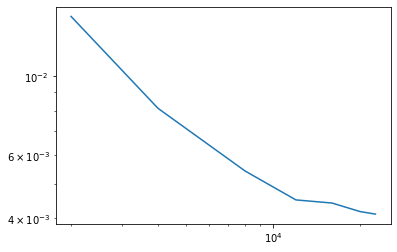

In [82]:
#Plot
plt.plot(structures,errors)
plt.xscale('log')
plt.yscale('log')

## Test with more structures
From the above test, it seems like the learning curve is not saturated at 8400 structures. More than that, it is likely that more structures are required to saturate the learning curve for forces than for energies. The reason for this is likely because, as Edgar put it, "the structural variance in local atomic environments is larger than that in structures (where differences between constituent environments are to some degree averaged out), and energies are a structural property whereas forces are an environmental one."

In [7]:
ntrain = 12000

In [8]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [9]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  200.65254664421082 s


In [11]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  528.9466071128845 s


In [12]:
dump_obj('raw_data/X_sparse_12k.json', X_sparse_FPS)

In [9]:
X_sparse_FPS = load_obj('raw_data/X_sparse_12k.json')

In [13]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [15]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/12000 [00:00<?, ?it/s]

Time taken:  133693.43727827072 s


In [16]:
#Save kernel
np.save('raw_data/Knm_kernel_12k', Knm_FPS)

In [10]:
Knm_FPS = np.load('raw_data/Knm_kernel_12k.npy')

In [26]:
#Train GAP model
y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS, y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 256.91189646720886


In [27]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

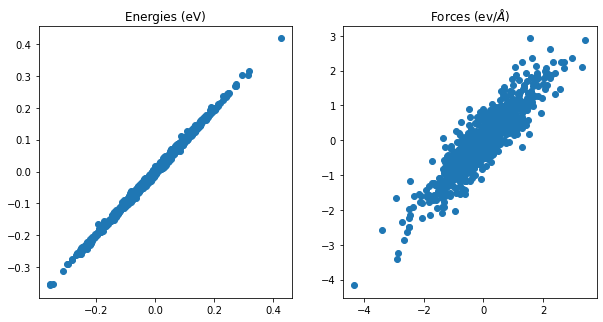

In [28]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

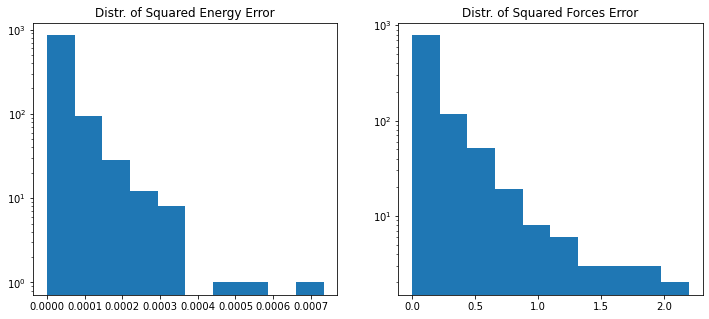

In [29]:
#Plot distribution of energy and force errors
f,p = plt.subplots(1,2,figsize=(12,5))
p[0].hist(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2)
p[0].set_title('Distr. of Squared Energy Error')
p[0].set_yscale('log')
p[1].hist((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2)
p[1].set_title('Distr. of Squared Forces Error')
p[1].set_yscale('log')

In [30]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [31]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [32]:
print(rmse_energy, rmse_forces)

0.006080112575327342 0.38821392440765734


## Test with more sparse points
For the same reasoning as no. of structures, it might be better to increase the number of sparse points per species in order to improve force predictions.

In [12]:
ntrain = 8400

In [14]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [36]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  136.2648470401764 s


In [37]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2500
nc = 2500
nn = 2500
no = 2500
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  532.3754510879517 s


In [38]:
dump_obj('raw_data/X_sparse_2500_ps.json', X_sparse_FPS)

In [15]:
X_sparse_FPS = load_obj('raw_data/X_sparse_2500_ps.json')

In [16]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/8400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#Save kernel
np.save('raw_data/Knm_kernel_2500_ps', Knm_FPS)

In [11]:
Knm_FPS = np.load('raw_data/Knm_kernel_2500_ps.npy')

In [18]:
#Train GAP model
y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 382.915452003479


In [27]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))
    if ifrm % 100 == 0:
        print(ifrm)

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

0
100
200
300
400
500
600
700
800
900


Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

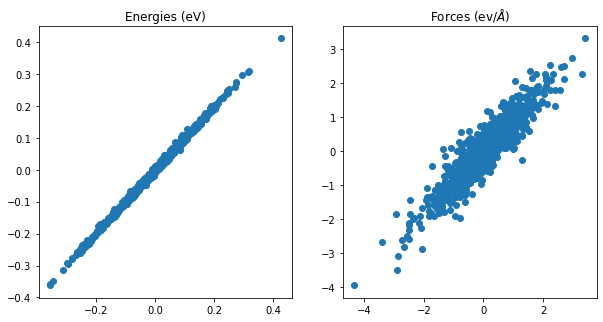

In [28]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

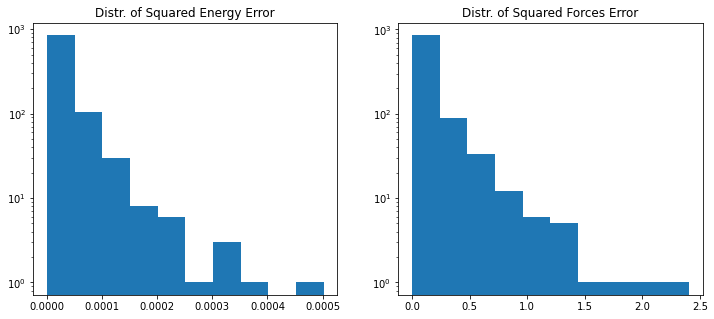

In [29]:
#Plot distribution of energy and force errors
f,p = plt.subplots(1,2,figsize=(12,5))
p[0].hist(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2)
p[0].set_title('Distr. of Squared Energy Error')
p[0].set_yscale('log')
p[1].hist((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2)
p[1].set_title('Distr. of Squared Forces Error')
p[1].set_yscale('log')

In [30]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [31]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [32]:
print(rmse_energy, rmse_forces)

0.005130534611366785 0.3493229574853867


## Effect of sparse points on GAP accuracy

From above, we can see that the errors using 2500 sparse points per species are:
- 5.1 meV for energy predictions
- 349 meV for force predictions

Using the "standard number of sparse points (~1600 per species), the errors are:
- 6.5 meV for energy predictions
- 440 meV for force predictions

We will now try and reduce the number of sparse points further to see the effect it has on the accuracy of predictions. If we can obtain similar accuracy with fewer sparse points this would lighten the model.

In [7]:
ntrain = 8400

In [8]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [9]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  135.2853865623474 s


In [ ]:
#Loop for testing dependency of number of sparse points on GAP model accuracy
rmses = np.zeros((3,3))
for ins, ns in enumerate([700, 1000, 1300]):
    print("Testing for ", ns, "sparse points per species")
    start=time()
    #Define hyperparameters and SOAP
    hypers["compute_gradients"] = False
    soap = SphericalInvariants(**hypers)
    
    #Calculate X_sparse
    nsparse    = {1: ns, 6: ns, 7: ns, 8: ns} #Select number of sparse environemnts per species
    compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
    print("Sparsifying training set...")
    X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
    
    #Define kernel and redefine hypers 
    hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
    soap = SphericalInvariants(**hypers)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel
    
    #Compute kernel
    print("Computing kernel...")
    Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Computing KNM", leave=False), X_sparse_FPS, kernel, soap)
    
    #Train model
    print("Training model...")
    full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
    
    #predict energies and forces for validation set
    npred=1000
    yvp = []
    fvp = []
    
    print("Making predictions on validation set...")
    for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
        manager_val = soap.transform(frm)
        yvp.append(full_model.predict(manager_val))
        fvp.append(full_model.predict_forces(manager_val))

    yval_pred = np.array(yvp).flatten()
    fval_pred = np.concatenate(fvp)
    
    #get energy and force rmses
    rmse_energy = np.sqrt(np.mean(
        ((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) 
         - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
    rmse_force = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
    
    print("For", nsparse, "sparse points per species :")
    print("Energy RMSE:", rmse_energy)
    print("Force RMSE:", rmse_force)
    print("Total time taken for full test:", time()-start)
    
    #Append info to numpy array
    rmses[ins] = [ns, rmse_energy, rmse_force]

#Save results
np.save('raw_data/sparse_points_test', rmses)
print(rmses)

Testing for  700 sparse points per species
Sparsifying training set...
Computing kernel...


Computing KNM:   0%|          | 0/8400 [00:00<?, ?it/s]

Training model...
Making predictions on validation set...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

For {1: 700, 6: 700, 7: 700, 8: 700} sparse points per species :
Energy RMSE: 0.01059553192607942
Force RMSE: 0.4960816496777539
Total time taken for full test: 43382.83862543106
Testing for  1000 sparse points per species
Sparsifying training set...
Computing kernel...


Computing KNM:   0%|          | 0/8400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training model...
Making predictions on validation set...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

For {1: 1000, 6: 1000, 7: 1000, 8: 1000} sparse points per species :
Energy RMSE: 0.008687983037324522
Force RMSE: 0.44055909465422843
Total time taken for full test: 60311.682034015656
Testing for  1300 sparse points per species
Sparsifying training set...
Computing kernel...


Computing KNM:   0%|          | 0/8400 [00:00<?, ?it/s]

In [23]:
print(rmses)

[[7.00000000e+02 1.05955319e-02 4.96081650e-01]
 [1.00000000e+03 8.68798304e-03 4.40559095e-01]
 [1.30000000e+03 7.41636688e-03 4.01705713e-01]]


In [22]:
np.save('raw_data/sparse_points_test', rmses)

## Effect of SOAP vector size on GAP accuracy

The large SOAP vector of 5670 severely reduces the speed of predictions, and so we will try and see how the accuracy of predictions is dependent on the size of the SOAP vector.

We will first try and use Bayesian hyperparameter optimisation to see if we can get good results using a smaller vector (and to see if we can improve results significantly using this Bayesian optimisation).

(We will reduce the SOAP vector to size 2520 by using nmax = 6 and lmax =6.

We will then reduce it to size 1800 by using nmax = 6 and lmax = 4.)

### Bayesian optimisation of hyperparameters

In [7]:
ntrain = 8400

In [8]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 4
hypers["max_radial"] = 6
hypers["max_angular"] = 6
soap = SphericalInvariants(**hypers)

In [69]:
X_train_FPS = np.zeros((len(train_set_FPS),4),dtype=int)
y_train_FPS = np.zeros(len(train_set_FPS))
for ifrm, frm in enumerate(train_set_FPS):
    symbols=frm.get_atomic_numbers()
    y_train_FPS[ifrm]=(frm.info['energy'])
    X_train_FPS[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

In [70]:
train_structures = train_set_FPS[:10000]
test_structures = val_set.copy()
y_train = y_train_FPS[:10000]-mlr.predict(X_train_FPS[:10000])

In [13]:
#define a searchspace
space = [Real(10**-6, 10**1, "log-uniform", name='alpha'),
        Real(1.0,3.0, "uniform", name="scale"),
        Real(3.0,7.0, "uniform", name="interaction_cutoff"),
        Real(0.05,0.6, "uniform", name="gaussian_sigma_constant"),
        Real(0.1,20.0, "uniform", name="exponent"),
        Real(0.1,20.0, "uniform", name="rate")
        ]

In [23]:
#define the SOAP objective
feature_gen_time = 0
hyper_opt_time = 0
model_fit_time = 0


@use_named_args(space)
def soap_objective(**params):
    global feature_gen_time
    global hyper_opt_time
    global model_fit_time
    
    new_params = params.copy()
    new_hypers = hypers.copy()
    
    #modify SOAP hypers
    new_hypers["interaction_cutoff"] = new_params["interaction_cutoff"]
    new_hypers["gaussian_sigma_constant"] = new_params["gaussian_sigma_constant"]
    new_hypers["cutoff_function_parameters"] = {"rate":new_params["rate"],
                                               "exponent":new_params["exponent"],
                                               "scale":new_params["scale"]}
    soap = SphericalInvariants(**new_hypers)
    
    #obtain optimal radial basis
    start_time = time()
    new_hypers = get_optimal_radial_basis_hypers_parallel(new_hypers,train_structures,num_cores=-1,
                                                          expanded_max_radial=20)
    hyper_opt_time += time() - start_time
    
    #update model parameters
    model.set_params(alpha=new_params["alpha"])
    
    #calculate SOAP features
    start_time = time()
    X_train = get_features_parallel(train_structures, bsize=200, n_cores=60)
    feature_gen_time += time() - start_time
    
    #Model training and scoring
    start_time = time()
    #in production it might make sense to increase the k-fold to 5, given that bayes opt makes the noise free asummption
    #splits = list(GroupKFold(n_splits=3).split(X_train,y_train)
    score = -np.mean(cross_val_score(model, X_train, y_train, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))
    model_fit_time += time() - start_time
    print("--eval--")
    
    #return n-fold cross val
    return score


In [72]:
#Perform Bayseian hyperparameter optimisation
feature_gen_time = 0
hyper_opt_time = 0
model_fit_time = 0

model = Ridge()

# We provide a reasonable first guess.
# Parameters reported in 10.1039/C9CP04489B Engel et al.  
# model alpha, scale, cutoff, sigma, exponent, rate
reasonable_guess = [1e-05,2.0,4.5,0.3,3,1]

checkpoint_saver = CheckpointSaver("./checkpoint_solver.pkl", compress=9)

print("starting")
start_time_total = time()

# provide search space, number of total objective function calls, a sead, an initial guess (optional)
# the number of jobs to optimize the aquisition function (LBFGS) and a callback (checkpoint saver)

#---------- actual optimization is called here -------------

res_gp = gp_minimize(soap_objective, space, n_calls=100, random_state=0,\
                     x0=reasonable_guess, n_jobs=-1, callback=[checkpoint_saver])

#------------------------------------------------------------

print("--- 25 steps took %.0f seconds ---" % (time() - start_time_total))
print("--- feature generation took %.0f seconds ---" % (feature_gen_time))
print("--- model fitting took %.0f seconds ---" % (model_fit_time))
print("--- hyper optimization took %.0f seconds ---" % (hyper_opt_time))

dump(res_gp, "solver_final.pkl")

print("finished")

starting
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--- 25 steps took 9668 seconds ---
--- feature generation took 753 seconds ---
--- model fi

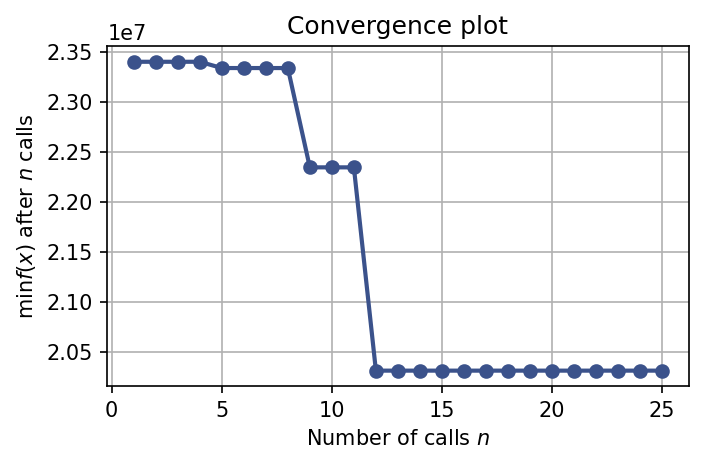

In [34]:
plt.figure(dpi=150,figsize=(5.,3.))
_ = plot_convergence(res_gp)

In [15]:
#we can also load the last OptimizeResult
res_gp = load("checkpoint_solver.pkl")

In [16]:
# model alpha, scale, cutoff, sigma, exponent, rate
res_gp.x

[4.954073578738684e-06,
 2.939618135493498,
 5.612560143191751,
 0.14400027182482483,
 7.227228122693548,
 15.038654210247282]

In [19]:
# model alpha, scale, cutoff, sigma, exponent, rate
hypers["interaction_cutoff"] = res_gp.x[2]
hypers["gaussian_sigma_constant"] = res_gp.x[3]
hypers["cutoff_function_parameters"] = {"rate":res_gp.x[5],
                                               "exponent":res_gp.x[4],
                                               "scale":res_gp.x[1]}

In [87]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [88]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  89.05611300468445 s


In [89]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1300
nc = 1300
nn = 1300
no = 1300
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  254.23383378982544 s


In [76]:
dump_obj('raw_data/X_sparse_bayes_hypers.json', X_sparse_FPS)

In [77]:
X_sparse_FPS = load_obj('raw_data/X_sparse_bayes_hypers.json')

In [90]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [79]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/8400 [00:00<?, ?it/s]

Time taken:  32022.724442005157 s


In [80]:
#Save kernel
np.save('raw_data/Knm_kernel_bayes_hypers', Knm_FPS)

In [83]:
Knm_FPS = np.load('raw_data/Knm_kernel_bayes_hypers.npy')

In [93]:
#Test model with optimal hyperparameters and previously-determined optimal regularizers
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 126.57166242599487


In [95]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

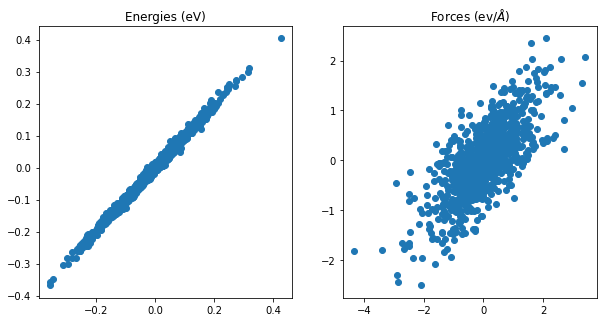

In [96]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

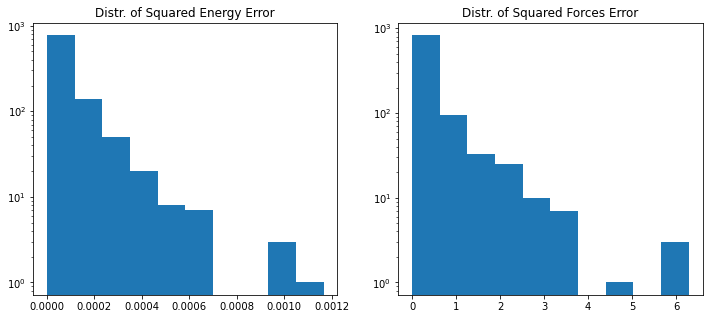

In [97]:
#Plot distribution of energy and force errors
f,p = plt.subplots(1,2,figsize=(12,5))
p[0].hist(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2)
p[0].set_title('Distr. of Squared Energy Error')
p[0].set_yscale('log')
p[1].hist((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2)
p[1].set_title('Distr. of Squared Forces Error')
p[1].set_yscale('log')

In [98]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [99]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [100]:
print(rmse_energy, rmse_forces)

0.009091426756804376 0.6141212598886958


In [111]:
#Test with many different regularizers
for ereg in np.logspace(-4,1,6):
    for freg in np.logspace(int(np.log10(ereg))+1, 2, 2-int(np.log10(ereg))):
        print("Training GAP model on energy reg", ereg, "and forces reg", freg)
        full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                                grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[ereg,freg], jitter=1e-9, 
                                solver = 'RKHS')
        npred=100
        yvp = []
        fvp = []

        for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
            manager_val = soap.transform(frm)
            yvp.append(full_model.predict(manager_val))
            fvp.append(full_model.predict_forces(manager_val))

        yval_pred = np.array(yvp).flatten()
        fval_pred = np.concatenate(fvp)

        rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
        rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
        print("RMSE energy:", rmse_energy*1000, "meV/atom")
        print("RMSE forces:", rmse_forces*1000, "eV/angstrom")
        print("")

Training GAP model on energy reg 0.0001 and forces reg 0.001


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 21.85614091402979 meV/atom
RMSE forces: 570.382680169956 eV/angstrom

Training GAP model on energy reg 0.0001 and forces reg 0.01


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 8.503823614183075 meV/atom
RMSE forces: 741.8084873081038 eV/angstrom

Training GAP model on energy reg 0.0001 and forces reg 0.1


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 10.980349071260878 meV/atom
RMSE forces: 1158.3101869617299 eV/angstrom

Training GAP model on energy reg 0.0001 and forces reg 1.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 11.569496896649541 meV/atom
RMSE forces: 1241.9672590956902 eV/angstrom

Training GAP model on energy reg 0.0001 and forces reg 10.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 11.577447027013271 meV/atom
RMSE forces: 1243.1779708242013 eV/angstrom

Training GAP model on energy reg 0.0001 and forces reg 100.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 11.577526830518652 meV/atom
RMSE forces: 1243.1901364192213 eV/angstrom

Training GAP model on energy reg 0.001 and forces reg 0.01


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 21.856140826833812 meV/atom
RMSE forces: 570.3826879049328 eV/angstrom

Training GAP model on energy reg 0.001 and forces reg 0.1


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 8.503826307084376 meV/atom
RMSE forces: 741.8085339605957 eV/angstrom

Training GAP model on energy reg 0.001 and forces reg 1.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 10.980119983615152 meV/atom
RMSE forces: 1158.3015738641773 eV/angstrom

Training GAP model on energy reg 0.001 and forces reg 10.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 11.569134246662353 meV/atom
RMSE forces: 1241.9493339149865 eV/angstrom

Training GAP model on energy reg 0.001 and forces reg 100.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 11.57708228866739 meV/atom
RMSE forces: 1243.1598742371036 eV/angstrom

Training GAP model on energy reg 0.01 and forces reg 0.1


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 21.856132108150085 meV/atom
RMSE forces: 570.3834614085897 eV/angstrom

Training GAP model on energy reg 0.01 and forces reg 1.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 8.50409555158902 meV/atom
RMSE forces: 741.8132513311398 eV/angstrom

Training GAP model on energy reg 0.01 and forces reg 10.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 10.957539601333355 meV/atom
RMSE forces: 1157.4549386912854 eV/angstrom

Training GAP model on energy reg 0.01 and forces reg 100.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 11.533532136158735 meV/atom
RMSE forces: 1240.1931563477956 eV/angstrom

Training GAP model on energy reg 0.1 and forces reg 1.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 21.8552641687319 meV/atom
RMSE forces: 570.4609036787238 eV/angstrom

Training GAP model on energy reg 0.1 and forces reg 10.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 8.530456586694813 meV/atom
RMSE forces: 742.7037500481163 eV/angstrom

Training GAP model on energy reg 0.1 and forces reg 100.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 9.992634427891671 meV/atom
RMSE forces: 1119.5563011540764 eV/angstrom

Training GAP model on energy reg 1.0 and forces reg 10.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 21.79789514722726 meV/atom
RMSE forces: 578.7846537225608 eV/angstrom

Training GAP model on energy reg 1.0 and forces reg 100.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 9.78908117418112 meV/atom
RMSE forces: 846.1123795928893 eV/angstrom

Training GAP model on energy reg 10.0 and forces reg 100.0


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE energy: 25.119278905640154 meV/atom
RMSE forces: 813.3106574345037 eV/angstrom



The errors using the "optimal SOAP hyperparameters" from Bayesian optimisation were actually very disappointing. Even when using regularization constants of 5e-6 and 5e-5 for energies/forces (optimal alpha from Bayesian optimisation) (resuls not shown here). So I will just use the previously determined optimal hyperparameters and test to see how errors with those differ when using a smaller nmax and lmax.

For comparison, the errors when using the same (standard ~1600) sparse points and nmax = 9 with lmax = 6, the errors were:
- Energies: 6.5 meV/atom
- Forces: 440 meV/angstrom

### Test with nmax = 6 and lmax = 6

In [10]:
ntrain = 8400

In [11]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [12]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 6
hypers["max_radial"] = 6
hypers["max_angular"] = 6
soap = SphericalInvariants(**hypers)

In [13]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  104.83498120307922 s


In [14]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  191.29510807991028 s


In [15]:
dump_obj('raw_data/X_sparse_hypers_6_6.json', X_sparse_FPS)

In [9]:
X_sparse_FPS = load_obj('raw_data/X_sparse_hypers_6_6.json')

In [16]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [17]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/8400 [00:00<?, ?it/s]

Time taken:  44075.01264023781 s


In [18]:
#Save kernel
np.save('raw_data/Knm_kernel_hypers_6_6', Knm_FPS)

In [10]:
Knm_FPS = np.load('raw_data/Knm_kernel_hypers_6_6.npy')

In [19]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 175.52173447608948


In [20]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

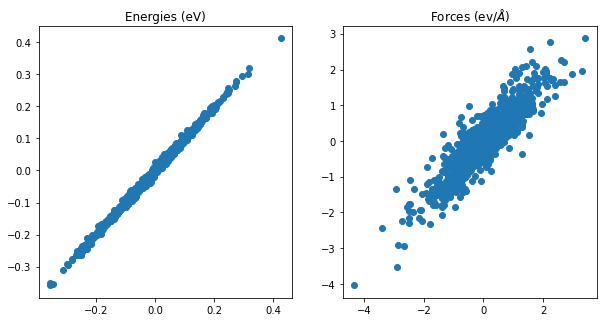

In [21]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [22]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [23]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [24]:
print(rmse_energy, rmse_forces)

0.006548234689141074 0.4055597191880272


In [25]:
np.savetxt('hyper66_results.txt', np.array([rmse_energy, rmse_forces]))

### Test with nmax = 6 and lmax = 4

In [26]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 6
hypers["max_radial"] = 6
hypers["max_angular"] = 4
soap = SphericalInvariants(**hypers)

In [27]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  78.42651867866516 s


In [28]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  195.39403557777405 s


In [29]:
dump_obj('raw_data/X_sparse_hypers_6_4.json', X_sparse_FPS)

In [9]:
X_sparse_FPS = load_obj('raw_data/X_sparse_hypers_6_4.json')

In [30]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [31]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/8400 [00:00<?, ?it/s]

Time taken:  30409.081037521362 s


In [32]:
#Save kernel
np.save('raw_data/Knm_kernel_hypers_6_4', Knm_FPS)

In [10]:
Knm_FPS = np.load('raw_data/Knm_kernel_hypers_6_4.npy')

In [33]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 174.72301483154297


In [34]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

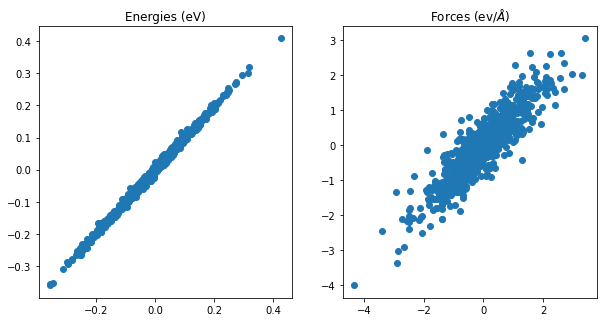

In [35]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [36]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [37]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [38]:
print(rmse_energy, rmse_forces)

0.006718575946417086 0.4073526786451771


In [39]:
np.savetxt('hyper64_results.txt', np.array([rmse_energy, rmse_forces]))

In [34]:
#Compute kernel
start=time()
Knm_FPS_2 = compute_KNM(tqdm(train_set_FPS[int(ntrain/2):ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/50 [00:00<?, ?it/s]

Time taken:  24.271981716156006 s


In [ ]:
def get_features_parallel(atoms_objects, bsize=1000, n_cores = 4):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        Do this in parallel
    '''
    blocks = []
    for iblk, blk in enumerate(range(0, len(atoms_objects), bsize)):
        blocks.append(atoms_objects[iblk*bsize:(iblk+1)*bsize])
    with parallel_backend(backend="loky"):
        results = Parallel(n_jobs=n_cores)(delayed(get_features)(frames, batch_size=10000, 
                                                                 progress_bar=False) for frames in blocks)

## Create learning curves for energy and force predictions

In [12]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [13]:
ntrain = 14000

In [14]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  184.64628720283508 s


In [15]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2000
nc = 2000
nn = 2000
no = 2000
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  379.64201068878174 s


In [16]:
dump_obj('raw_data/X_sparse_14k.json', X_sparse)

In [59]:
X_sparse = load_obj('raw_data/X_sparse_14k.json')

In [17]:
#Define kernel 
hypers["compute_gradients"] = True
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [18]:
start=time()
Knm = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/14000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Time taken:  96163.14823389053 s


Knm[:nstructs] has the energy row of each structure 
Knm[nstructs:] has the force rows of each structure, which is organised as follows:
- There are natoms * 3 rows per structure
- Organised in the order of structures in nstruct
- i.e., to extract the force rows for structure with index 0, you have to figure out the number of atoms in that structure (e.g. 40), and multiply by 3, and then extract those indices from the end of the energy rows for all structures (as this is the structure with index 0). I.e. : Knm[nstruct:(nstruct+(40*3))]

In [19]:
np.save('raw_data/Knm_kernel_14k', Knm)
print("KNM saved")

KNM saved


In [21]:
nat_per_struct=[]
for frm in train_set_FPS[:ntrain]:
    nat_per_struct.append(len(frm))

In [23]:
print(ntrain+(np.sum(nat_per_struct)*3))

3204416


In [ ]:
for i in range(1000,15000,1000):
    nforce_rows = np.sum(nat_per_struct[:i])*3
    Knm_new = np.zeros((i+nforce_rows, Knm.shape[1]))
    Knm_new[:i] = Knm[:i]
    Knm_new[i:] = Knm[ntrain:(ntrain+nforce_rows)]
    np.save('raw_data/Knm_kernel_'+str(i), Knm_new)
    print('Kernel saved for', i, 'structures')

(253702, 8000)
[-0.22825986 -0.09370855  0.00751758 ... -0.31456515 -0.10016761
 -0.1177761 ]
Kernel saved for 1000 structures
(532517, 8000)
[ 0.10949375 -0.07920935 -0.1026023  ...  0.00335623 -0.00078205
  0.01982576]
Kernel saved for 2000 structures
(711930, 8000)
[ 0.19474965  0.24129682  0.08497942 ... -0.00552133 -0.01466515
  0.03994843]
Kernel saved for 3000 structures
(890734, 8000)
Kernel saved for 4000 structures
(1086788, 8000)
[-0.03177876 -0.0051537   0.02355903 ... -0.03347209 -0.00398264
 -0.00775676]
Kernel saved for 5000 structures
(1291605, 8000)
[-0.25757596 -0.17430337 -0.12964612 ...  0.27449162  0.24753385
 -0.19465438]
Kernel saved for 7000 structures
(1721399, 8000)
[ 0.08084996 -0.03395546 -0.08494478 ...  0.01129545  0.01199071
 -0.0099253 ]
Kernel saved for 8000 structures
(1952730, 8000)
[ 0.00312832 -0.02521719 -0.02602598 ...  0.17170759 -0.02046489
  0.24435956]
Kernel saved for 9000 structures
(2189428, 8000)
[-0.07201637 -0.07213623 -0.02718272 ...  0

In [ ]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm, X_sparse, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...


In [42]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

In [43]:
np.save('results_data/yval_pred_14k', yval_pred)
np.save('results_data/fval_pred_14k', fval_pred)

In [44]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [45]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [46]:
print('RMSE energy:', rmse_energy, 'eV/atom')
print('RMSE forces:', rmse_forces, 'eV/angstrom')

RMSE energy: 0.005445800449245529 eV/atom
RMSE forces: 0.38404849064855484 eV/angstrom


In [ ]:
for i in range(1000,15000,1000):
    print('Creating model using', i, 'training structures...')
    Kernelnm = np.load('raw_data/Knm_kernel_'+str(i)+'.npy')
    full_model = train_gap_model(kernel, train_set_FPS[:i], Kernelnm, X_sparse, ytrain_FPS[:i], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:i]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
    npred=1000
    yvp = []
    fvp = []

    for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
        manager_val = soap.transform(frm)
        yvp.append(full_model.predict(manager_val))
        fvp.append(full_model.predict_forces(manager_val))

    yval_pred = np.array(yvp).flatten()
    fval_pred = np.concatenate(fvp)
    np.save('results_data/yval_pred_lc_'+str(i), yval_pred)
    np.save('results_data/fval_pred_lc_'+str(i), fval_pred)
    print("Predictions saved.")
    rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
    rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
    print('RMSE energy:', rmse_energy, 'eV/atom')
    print('RMSE forces:', rmse_forces, 'eV/angstrom')
    print("")